##Importing the required modules

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Preparing the data

In [ ]:
df = pd.read_csv('/content/stock_dataset.csv')

In [ ]:
df = df.drop(columns = ['Trades','Deliverable Volume','%Deliverble'])

In [ ]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14


In [ ]:
df.columns = df.columns.str.strip()

###Filling the missing Values

In [ ]:
numerical_cols =  df.select_dtypes(include = ('int64','int32','float64','float32')).columns

In [ ]:
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [ ]:
data = df.drop(columns = ['Date', 'Symbol', 'Series'])

###Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
data = ss.fit_transform(data)

##Creating the sequences (uses the data from past 10 days and predicts next day's Close Price)

In [ ]:
seq_length = 10

def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length])
    y.append(data[i + seq_length, 0])

  return np.array(X), np.array(y)

In [ ]:
X, y = create_sequences(data, seq_length)

##Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##Defining the LSTM model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (seq_length, X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 10, 50)              │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,501 (130.86 KB)

 Trainable params: 33,501 (130.86 KB)

 Non-trainable params: 0 (0.00 B)

##Training the model

In [ ]:
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adam(0.001),
              metrics = ['mse'])

history = model.fit(X_train, y_train, epochs = 25, verbose = 1, validation_data = (X_test, y_test), batch_size = 32)

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2512 - mse: 0.2512 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 9/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.013

<Axes: >

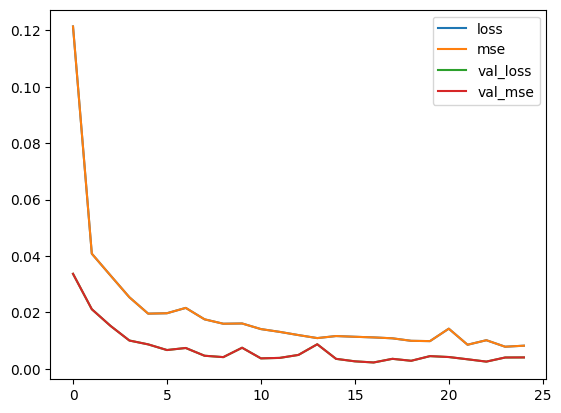

In [ ]:
pd.DataFrame(history.history).plot()

##Making predictions

In [ ]:
preds = model.predict(X_test)
preds = preds.ravel()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
res = pd.DataFrame(data = {'Prediction': preds.ravel(),
                           'True': y_test})

In [ ]:
res.head(10)

,Prediction,True
0,0.154547,0.096345
1,1.803385,1.806229
2,1.293377,1.253115
3,-0.983162,-1.004699
4,-1.084305,-1.084789
5,1.593242,1.483536
6,-0.423229,-0.452881
7,1.998149,1.969260
8,-0.335162,-0.318620
9,-0.266000,-0.276890


##Visualising the Predictions

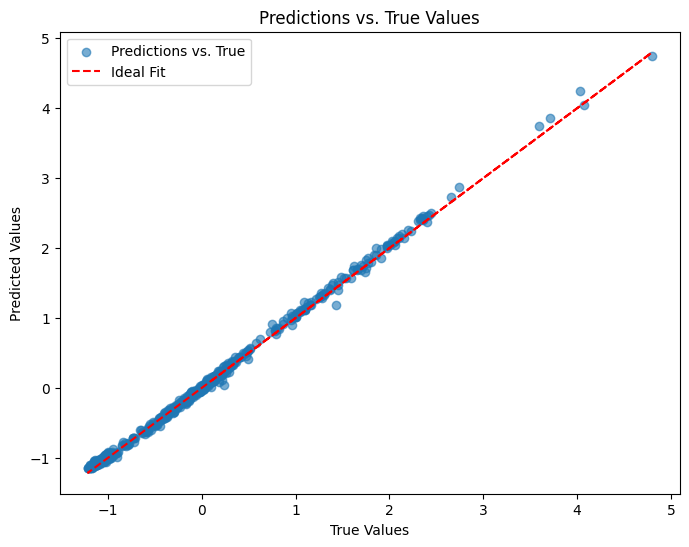

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.6, label="Predictions vs. True")
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Ideal Fit")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs. True Values")
plt.legend()
plt.show()